In [1]:
import numpy as np
import torch
import cv2
import sys
import matplotlib.pyplot as plt

from blazebase import resize_pad, denormalize_detections
from blazeface import BlazeFace
from blazepalm import BlazePalm
from blazeface_landmark import BlazeFaceLandmark
from blazehand_landmark import BlazeHandLandmark
import mediapipe as mp

from utils import *
from visualization import (
    draw_detections, draw_landmarks, draw_roi,
    draw_normalized_hand_landmarks_on_cropped,
    HAND_CONNECTIONS, FACE_CONNECTIONS
)

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

hand_regressor = BlazeHandLandmark().to(gpu)
hand_regressor.load_weights("blazehand_landmark copy.pth")


/Users/hjp/.pyenv/versions/3.10.5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


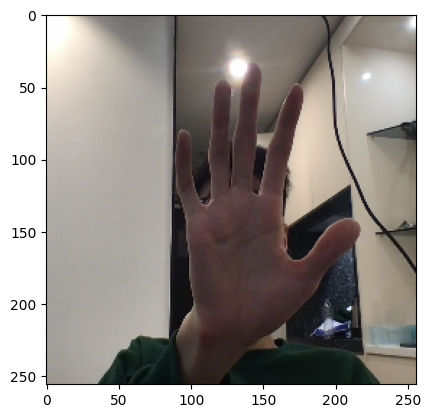

In [2]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
for i in range(10) :
    ret, np_image = cap.read()
cap.release()


input_image_np = cv2.resize(
    cv2.cvtColor(
        np_image[:, 200:-200],
        cv2.COLOR_BGR2RGB
    ),
        (256, 256),
)

input_image_tensor = torch.Tensor(
    input_image_np.transpose(2, 0, 1),
).unsqueeze(0) / 255.0

plt.imshow(input_image_np)

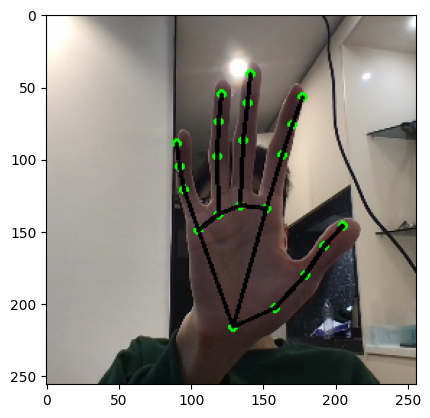

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/var/folders/rj/hhfqjm6x0zj77chzkv2pwrgr0000gn/T/ipykernel_36612/3206213341.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  landmark_mediapipe = torch.Tensor(landmark_mediapipe)


torch.Size([1, 21, 3])


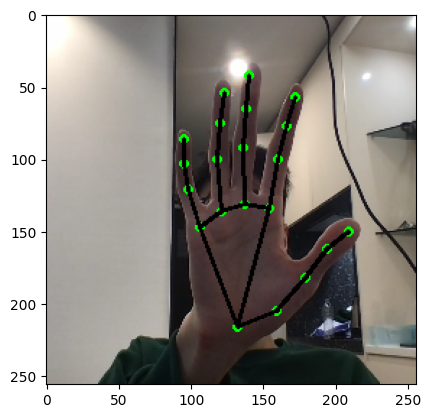

In [3]:
# blazehand
hand_flag, handed, landmarks_blaze = hand_regressor(input_image_tensor)
input_image_vis1 = input_image_np.copy()
draw_normalized_hand_landmarks_on_cropped(
    input_image_vis1,
    landmarks_blaze[0],
)
plt.imshow(input_image_vis1)
plt.show()


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


# mediapipe
with mp_hands.Hands(
    static_image_mode = False,
    model_complexity  = 1,
    min_detection_confidence = 0.2,
    min_tracking_confidence =  0.2,
) as hands:

    results = hands.process(input_image_np)
    landmark_mediapipe  = []
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:            
            landmark_mediapipe.append(
                calc_normalized_landmark_list(hand_landmarks)
            )
    else :
        print("no hand")
        
    landmark_mediapipe = torch.Tensor(landmark_mediapipe)

    print(landmark_mediapipe.shape)

    input_image_vis2 = input_image_np.copy()
    draw_normalized_hand_landmarks_on_cropped(
        input_image_vis2,
        landmark_mediapipe[0]
    )

    plt.imshow(input_image_vis2)

In [4]:
print(landmark_mediapipe.shape, landmarks_blaze.shape)
print(landmark_mediapipe.dtype, landmarks_blaze.dtype)


torch.Size([1, 21, 3]) torch.Size([1, 21, 3])
torch.float32 torch.float32


In [5]:
batch_size = 20
net_inputs = torch.stack([
    input_image_tensor[0] for i in range(batch_size)
])
net_target = torch.stack(
    [landmark_mediapipe[0] for i in range(batch_size)]
)

In [6]:
net_inputs.shape, net_target.shape

(torch.Size([20, 3, 256, 256]), torch.Size([20, 21, 3]))

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from blazebase import BlazeLandmark, BlazeBlock

class BlazeHandLandmark(BlazeLandmark):
    """The hand landmark model from MediaPipe."""
    def __init__(self):
        super(BlazeHandLandmark, self).__init__()

        # size of ROIs used for input
        self.resolution = 256

        self._define_layers()

    def _define_layers(self):
        self.backbone1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=24,
                kernel_size=3, stride=2, padding=0, bias=True
            ),
            nn.ReLU(inplace=False),

            BlazeBlock(24, 24, 5),
            BlazeBlock(24, 24, 5),
            BlazeBlock(24, 48, 5, 2),
        )

        self.backbone2 = nn.Sequential(
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 96, 5, 2),
        )

        self.backbone3 = nn.Sequential(
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5, 2),
        )

        self.backbone4 = nn.Sequential(
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5, 2),
        )

        self.blaze5 = BlazeBlock(96, 96, 5)
        self.blaze6 = BlazeBlock(96, 96, 5)
        self.conv7 = nn.Conv2d(96, 48, 1, bias=True)

        self.backbone8 = nn.Sequential(
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 96, 5, 2),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
        )

        self.hand_flag = nn.Conv2d(288, 1, 2, bias=True)
        self.handed = nn.Conv2d(288, 1, 2, bias=True)
        self.landmarks = nn.Conv2d(288, 63, 2, bias=True)


    def forward(self, x):
        if x.shape[0] == 0:
            return torch.zeros((0,)), torch.zeros((0,)), torch.zeros((0, 21, 3))

        #print(x.shape, x.min(), x.mean(), x.max(), x.dtype)
        
        print(x.requires_grad)

        x = F.pad(x, (0, 1, 0, 1), "constant", 0)
        x.requires_grad_(True)

        print(x.requires_grad)
        
        x = self.backbone1(x)
        y = self.backbone2(x)
        z = self.backbone3(y)
        w = self.backbone4(z)

        print("xyzw")
        print(
            x.requires_grad,
            y.requires_grad,
            z.requires_grad,
            w.requires_grad,
        )


        z = z + F.interpolate(w, scale_factor=2, mode='bilinear')
        z = self.blaze5(z)

        y = y + F.interpolate(z, scale_factor=2, mode='bilinear')
        y = self.blaze6(y)
        y = self.conv7(y)

        x = x + F.interpolate(y, scale_factor=2, mode='bilinear')

        x = self.backbone8(x)

        print(x.requires_grad)
        print()

        hand_flag = self.hand_flag(x).view(-1).sigmoid()
        handed = self.handed(x).view(-1).sigmoid()
        landmarks = self.landmarks(x).view(-1, 21, 3) / 256

        '''
        print(
            x.shape,
            self.landmarks(x).shape,
            landmarks.shape,
        )
        '''
        #print(landmarks)

        return hand_flag, handed, landmarks

        
model = BlazeHandLandmark()
model.load_weights("blazehand_landmark copy.pth")
model.train()

model_params = hand_regressor.parameters()

In [8]:
sample = torch.ones((3, 256, 256), requires_grad=True)
sample.dtype, sample.shape

(torch.float32, torch.Size([3, 256, 256]))

In [9]:
model.backbone1(sample).requires_grad

False

In [17]:
class SNet(torch.nn.Module) :
    def __init__(self) -> None:
        super(SNet, self).__init__()
        self.bb = nn.Conv2d(
            in_channels=3, out_channels=24,
            kernel_size=3, stride=2, padding=0, bias=True
        )
        
    def forward(self, x) :
        return self.bb(x)

ssmodel = SNet()
ssmodel.train()

pred = ssmodel(sample)

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

sample_input = torch.ones((3, 32, 32), requires_grad=True)

net = Net()

pred2 = net(sample_input)


In [18]:
pred2.requires_grad

False

In [14]:
pred.requires_grad, sample.requires_grad

(False, True)

In [43]:
crieterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 0.001,
)

In [44]:
import tqdm
epochs = 10

net_inputs.requires_grad_(True)


for epoch in range(epochs) :

    optimizer.zero_grad()

    _, _, hand_landmark_pred = model(
        net_inputs
    )

    #print(hand_landmark_pred.requires_grad)

    loss = crieterion(hand_landmark_pred, net_target)
    loss.requires_grad_(True)
    print(f"epc:{epoch}, loss:{loss}")
    loss.backward()
    optimizer.step()


True
True
xyzw
False False False False
False

epc:0, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:1, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:2, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:3, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:4, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:5, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:6, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:7, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:8, loss:0.0016599113587290049
True
True
xyzw
False False False False
False

epc:9, loss:0.0016599113587290049
